1. Enable data augmentation, and precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

# Setup

## Imports

In [1]:
from utils import *

## Define Useful Features

In [3]:
jtplot_style()

In [4]:
use_sample = False
batch_size = 64
architecture = resnext101_64
frac_val = 0.001

In [5]:
if use_sample: DIR_DATA /= 'sample'

## Load Data

In [6]:
def get_data(sz, bs, _tfms=None):
    _val_idxs = get_cv_idxs(len(list(DIR_DATA.glob('train/*.jpg'))), val_pct=frac_val)
    if _tfms is None: _tfms = tfms_from_model(architecture, sz)
    return ImageClassifierData.from_csv(DIR_DATA, 'train', DIR_DATA / 'labels.csv',
                                        bs, _tfms, _val_idxs, suffix='.jpg')

In [7]:
data = get_data(224, batch_size)

In [ ]:
show_images(next(iter(data.trn_dl))[0][:9].permute(0, 2, 3, 1).cpu().numpy(),
           pixel_range='auto')

# Initial Training

In [8]:
model = ConvLearner.pretrained(architecture, data, precompute=True)

## Find Suitable Learning Rate

In [10]:
model.lr_find()

 89%|████████▉ | 143/160 [00:01<00:00, 20.36it/s, loss=2.93]


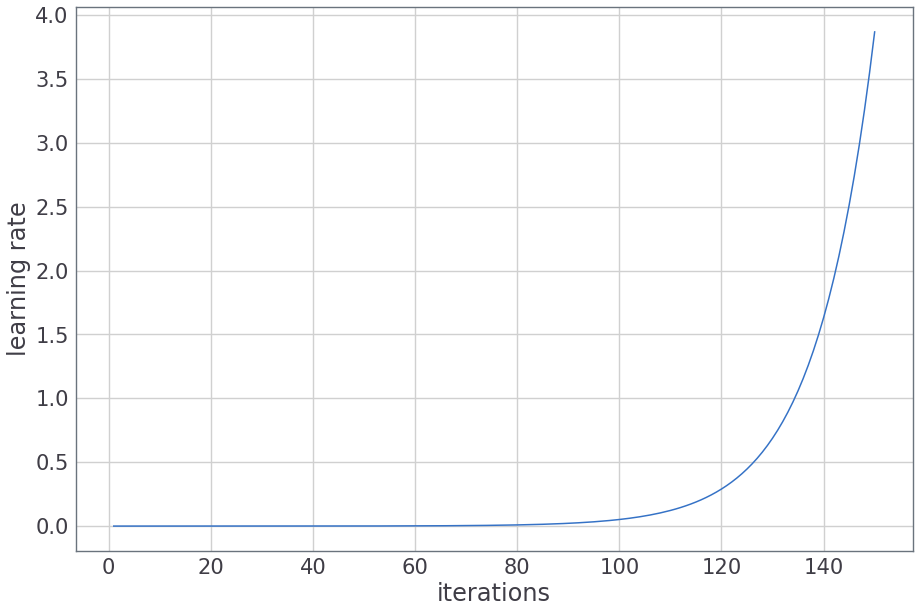

In [11]:
model.sched.plot_lr()

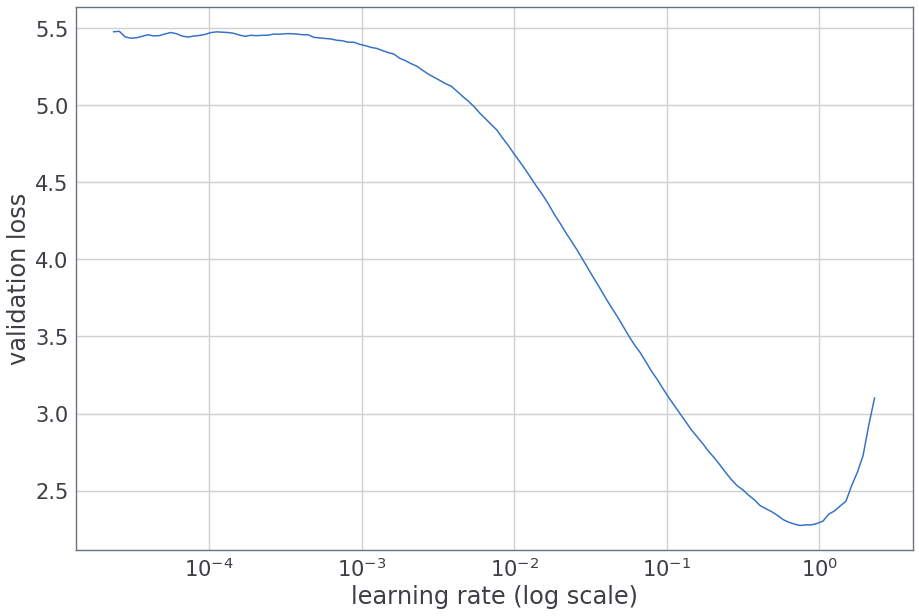

In [12]:
model.sched.plot()

## Train

In [13]:
model.fit(1e-1, 2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.579697   0.022399   1.0       
    1      0.344393   0.026055   1.0                         



[array([0.02606]), 1.0]

# Improved Model

## Data Augmentation

In [9]:
_tfms = tfms_from_model(architecture, 224,
                        aug_tfms=transforms_side_on, max_zoom=1.1)
data = get_data(224, batch_size, _tfms)

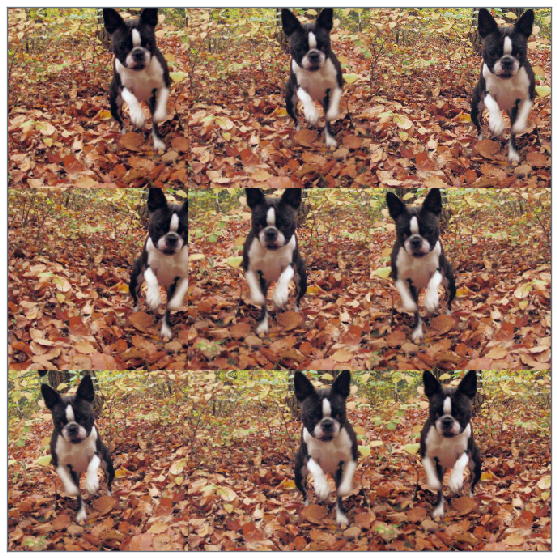

In [24]:
show_images([next(iter(data.aug_dl))[0][0].permute(1, 2, 0).cpu().numpy()
            for _ in range(9)],
           pixel_range='auto')

In [15]:
model.set_data(data)
model.precompute = False

In [16]:
model.fit(1e-1, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.27928    0.016284   1.0       
    1      0.245354   0.019947   1.0                         



[array([0.01995]), 1.0]

## Bigger Image Size

In [10]:
_tfms = tfms_from_model(architecture, 299,
                        aug_tfms=transforms_side_on, max_zoom=1.1)
data = get_data(299, batch_size, _tfms)

In [11]:
model.set_data(data)

In [13]:
model.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.203443   0.132411   0.9       
    1      0.202494   0.113065   0.9                         
    2      0.192045   0.084114   1.0                         
    3      0.193541   0.096971   1.0                         
    4      0.175606   0.108603   0.9                         
    5      0.189554   0.108496   0.9                         
    6      0.162939   0.097904   1.0                         



[array([0.0979]), 1.0]

In [14]:
model.save(DIR_CHECKPOINTS / 'model')

In [ ]:
!gcloud compute instances stop fastdl

Stopping instance(s) fastdl...\                                                